# 📈 Temporal Impact Analysis - GRU Model

## Comprehensive Analysis of Short-term vs Long-term Impact Patterns

**Objective:** Compare the short-term (12w) vs. long-term (24w) impact of demographics, clinical conditions, and mindfulness interventions

**Key Analysis Components:**
- ⏰ Temporal Feature Evolution Analysis
- 🔄 Short vs Long-term Predictor Comparison
- 👥 Demographics Impact Over Time
- 🏥 Clinical Progression Analysis
- 💊 Mindfulness Intervention Effectiveness
- 📊 Recovery Pattern Identification

---
**GRU Model Performance:**
- 12w: MAE 4.533 ± 0.712, R² 0.233
- 24w: Expected similar performance
---

In [1]:
# 📚 Import Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning & Time Series Analysis
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Statistical Analysis
from scipy import stats
from scipy.stats import pearsonr, spearmanr, wilcoxon, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

# File handling and utilities
import json
from pathlib import Path
from datetime import datetime
import itertools

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Plotting configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("🚀 Libraries loaded successfully!")
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🚀 Libraries loaded successfully!
📅 Analysis Date: 2025-10-01 13:04:32


In [5]:
# 📂 Load Corrected Data and Setup Paths
from pathlib import Path
import sys

# Setup paths for corrected data
current_dir = Path.cwd()
src_track1_path = current_dir if current_dir.name == 'SRC_Track1' else current_dir / 'SRC_Track1'
BASE_PATH = src_track1_path.parent
DATA_PATH = BASE_PATH / "Track1_Data" / "processed"
RESULTS_PATH = BASE_PATH / "Results_Corrected_Data"

# Add SRC_Track1 to path for model imports
sys.path.append(str(BASE_PATH / "SRC_Track1"))

print(f"📁 Base Path: {BASE_PATH}")
print(f"📁 Data Path: {DATA_PATH}")
print(f"📁 Results Path: {RESULTS_PATH}")

# Load corrected dataset
train_data = pd.read_excel(DATA_PATH / 'train_corrected_features.xlsx')

print("📊 Dataset Overview:")
print(f"   Training samples: {len(train_data)}")
print(f"   Dataset shape: {train_data.shape}")

# Load feature metadata if available
metadata_path = DATA_PATH / "feature_metadata.json"
if metadata_path.exists():
    with open(metadata_path, 'r') as f:
        feature_metadata = json.load(f)
    print(f"✅ Loaded feature metadata: {len(feature_metadata)} features documented")
else:
    feature_metadata = {}
    print("⚠️ Feature metadata not found")

# Define target columns and feature columns
target_cols = ['bdi_ii_after_intervention_12w', 'bdi_ii_follow_up_24w']
feature_cols = [col for col in train_data.columns if col not in target_cols + ['participant_id']]

print(f"📊 Analysis Setup:")
print(f"   Features: {len(feature_cols)}")
print(f"   Targets: {target_cols}")
print(f"   Feature columns: {feature_cols[:5]}... ({len(feature_cols)} total)")

# Display target statistics
print(f"\n📈 Target Statistics:")
for target in target_cols:
    if target in train_data.columns:
        stats = train_data[target].describe()
        print(f"   {target}: Mean={stats['mean']:.2f}, Std={stats['std']:.2f}, Range=[{stats['min']:.1f}, {stats['max']:.1f}]")

📁 Base Path: c:\Users\nikhi\Desktop\IEEE_EMBS_BHI_25_CSOSEN
📁 Data Path: c:\Users\nikhi\Desktop\IEEE_EMBS_BHI_25_CSOSEN\Track1_Data\processed
📁 Results Path: c:\Users\nikhi\Desktop\IEEE_EMBS_BHI_25_CSOSEN\Results_Corrected_Data
📊 Dataset Overview:
   Training samples: 167
   Dataset shape: (167, 26)
✅ Loaded feature metadata: 7 features documented
📊 Analysis Setup:
   Features: 24
   Targets: ['bdi_ii_after_intervention_12w', 'bdi_ii_follow_up_24w']
   Feature columns: ['age', 'hospital_center_id', 'bdi_ii_baseline', 'mindfulness_therapies_started', 'mindfulness_therapies_completed']... (24 total)

📈 Target Statistics:
   bdi_ii_after_intervention_12w: Mean=7.48, Std=7.27, Range=[0.0, 40.0]
   bdi_ii_follow_up_24w: Mean=6.71, Std=7.32, Range=[-1.0, 41.0]


In [3]:
# 🤖 Pre-trained Model Loader System
# Import the experiment framework and phase modules to recreate models
from experiment_framework import ExperimentFramework
from phase1_baseline_models import Phase1BaselineModels
from phase2_classical_ml import Phase2ClassicalML

class ResultsBasedModelLoader:
    """Load and recreate models from phase results JSON files"""
    
    def __init__(self, results_dir):
        self.results_dir = Path(results_dir)
        self.available_models = []
        self.framework = ExperimentFramework(random_seed=42)
        self._discover_models()
    
    def _discover_models(self):
        """Discover available models from phase results"""
        phase_files = list(self.results_dir.glob("phase*_results_*.json"))
        
        for phase_file in sorted(phase_files):
            try:
                with open(phase_file, 'r') as f:
                    results = json.load(f)
                
                phase_name = phase_file.stem.split('_results_')[0]
                
                for model_name, model_data in results.items():
                    if isinstance(model_data, dict) and 'mean_scores' in model_data:
                        mae = model_data['mean_scores'].get('test_mae', float('inf'))
                        r2 = model_data['mean_scores'].get('test_r2', -float('inf'))
                        
                        self.available_models.append({
                            'model_id': f"{phase_name}_{model_name}",
                            'phase': phase_name,
                            'model_name': model_name,
                            'mae': mae,
                            'r2': r2,
                            'results_file': phase_file,
                            'model_data': model_data
                        })
            except Exception as e:
                print(f"⚠️ Could not load {phase_file}: {e}")
        
        # Sort by R² (best first for temporal analysis)
        self.available_models.sort(key=lambda x: x['r2'], reverse=True)
        
        # Add ranks
        for i, model in enumerate(self.available_models):
            model['rank'] = i + 1
    
    def get_best_models(self, top_n=5):
        """Get top N models by R² score"""
        return self.available_models[:top_n]
    
    def recreate_model(self, model_info, X, y):
        """Recreate and train a model based on the stored results"""
        phase = model_info['phase']
        model_name = model_info['model_name']
        model_data = model_info['model_data']
        
        print(f"🔧 Recreating {phase}_{model_name}...")
        
        if phase == 'phase1':
            phase_module = Phase1BaselineModels(self.framework)
            models = phase_module.create_models()
        elif phase == 'phase2':
            phase_module = Phase2ClassicalML(random_seed=42)
            models = phase_module.create_models()
        else:
            raise ValueError(f"Phase {phase} not supported yet")
        
        # Get the model
        if model_name not in models:
            raise ValueError(f"Model {model_name} not found in {phase}")
        
        model = models[model_name]
        
        # Apply best hyperparameters if available
        if 'best_params' in model_data:
            best_params = model_data['best_params']
            print(f"   Applying best params: {list(best_params.keys())}")
            
            try:
                model.set_params(**best_params)
            except Exception as e:
                print(f"   ⚠️ Could not set all params: {e}")
        
        # Train the model
        print(f"   Training {model_name}...")
        model.fit(X, y)
        print(f"   ✅ Model trained successfully")
        
        return model

# Initialize the model loader
results_dir = RESULTS_PATH / "Model_Experiments"
if results_dir.exists():
    model_loader = ResultsBasedModelLoader(results_dir)
    
    print(f"🤖 Found {len(model_loader.available_models)} pre-trained model configurations")
    
    # Show top 5 models by R² score
    best_models = model_loader.get_best_models(5)
    print(f"\n🏆 Top 5 Models by R² Score:")
    for model in best_models:
        print(f"   Rank {model['rank']:2d}: {model['model_id']:25s} R²: {model['r2']:6.3f} MAE: {model['mae']:6.3f}")
else:
    print(f"❌ Results directory not found: {results_dir}")
    model_loader = None

🔬 Experiment Framework Initialized
📁 Results will be saved to: ..\Results\Model_Experiments
🆔 Experiment ID: 20251001_130438
🎲 Random Seed: 42
🤖 Found 116 pre-trained model configurations

🏆 Top 5 Models by R² Score:
   Rank  1: phase5_transformer        R²:  0.261 MAE:  4.646
   Rank  2: phase5_transformer        R²:  0.250 MAE:  4.675
   Rank  3: phase5_lstm_bidirectional R²:  0.203 MAE:  4.805
   Rank  4: phase5_lstm_stacked       R²:  0.202 MAE:  4.643
   Rank  5: phase1_lasso_regression   R²:  0.179 MAE:  4.709


In [6]:
# 📊 Load Corrected Data for Temporal Analysis
print("📊 Loading corrected training data...")

# Load the corrected training data
corrected_file = DATA_PATH / "train_corrected_features.xlsx"
if corrected_file.exists():
    df = pd.read_excel(corrected_file)
    print(f"✅ Loaded corrected data: {df.shape}")
    print(f"   Features: {df.shape[1]} columns")
    print(f"   Samples: {df.shape[0]} rows")
else:
    print(f"❌ Corrected file not found: {corrected_file}")
    print("   Falling back to engineered features...")
    df = pd.read_excel(DATA_PATH / "train_engineered_features.xlsx")
    print(f"⚠️ Using engineered data: {df.shape}")

# Map target column names (corrected vs original)
target_mapping = {
    '12w': 'bdi_ii_after_intervention_12w',
    '24w': 'bdi_ii_follow_up_24w'
}

# Display basic statistics
print(f"\n📈 Target Variable Statistics:")
for period, target_col in target_mapping.items():
    if target_col in df.columns:
        values = df[target_col].dropna()
        print(f"   {target_col} ({period}): {len(values)} samples, range [{values.min():.1f}, {values.max():.1f}], mean {values.mean():.2f}")
    else:
        print(f"   ⚠️ {target_col} not found in dataset")

# Get feature columns (exclude target variables and IDs)
excluded_cols = ['participant_id'] + list(target_mapping.values())
feature_cols = [col for col in df.columns if col not in excluded_cols]
print(f"\n🔧 Feature columns: {len(feature_cols)} features")

# Check data completeness for temporal analysis
valid_12w = df[target_mapping['12w']].notna() if target_mapping['12w'] in df.columns else pd.Series([False])
valid_24w = df[target_mapping['24w']].notna() if target_mapping['24w'] in df.columns else pd.Series([False])
both_valid = valid_12w & valid_24w

print(f"\n🎯 Temporal Analysis Data Availability:")
print(f"   12w targets available: {valid_12w.sum()}")
print(f"   24w targets available: {valid_24w.sum()}")
print(f"   Both timepoints available: {both_valid.sum()}")

# Preview the data
print(f"\n📝 Data Preview:")
preview_cols = list(target_mapping.values()) + feature_cols[:5]
display(df[preview_cols].head())

# Missing values check
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
if len(missing_summary) > 0:
    print(f"\n⚠️ Missing Values Summary (top 10):")
    for col, count in missing_summary.head(10).items():
        print(f"   {col}: {count} missing ({count/len(df)*100:.1f}%)")
else:
    print("\n✅ No missing values found!")

# Data quality metrics
data_quality = {
    'total_samples': len(df),
    'feature_count': len(feature_cols),
    'missing_rate': round(df.isnull().sum().sum() / (len(df) * len(df.columns)), 4),
    'has_both_targets': all(col in df.columns for col in target_mapping.values()),
    'temporal_pairs': both_valid.sum() if both_valid.any() else 0
}

print(f"\n✅ Data Quality for Temporal Analysis:")
for key, value in data_quality.items():
    print(f"   {key}: {value}")

print(f"\n🎯 Ready for temporal impact analysis!")
print(f"   Dataset shape: {df.shape}")
print(f"   Feature count: {len(feature_cols)}")
print(f"   Temporal pairs: {data_quality['temporal_pairs']}")
print(f"   Target columns: {list(target_mapping.values())}")

📊 Loading corrected training data...
✅ Loaded corrected data: (167, 26)
   Features: 26 columns
   Samples: 167 rows

📈 Target Variable Statistics:
   bdi_ii_after_intervention_12w (12w): 167 samples, range [0.0, 40.0], mean 7.48
   bdi_ii_follow_up_24w (24w): 167 samples, range [-1.0, 41.0], mean 6.71

🔧 Feature columns: 24 features

🎯 Temporal Analysis Data Availability:
   12w targets available: 167
   24w targets available: 167
   Both timepoints available: 167

📝 Data Preview:


,bdi_ii_after_intervention_12w,bdi_ii_follow_up_24w,age,hospital_center_id,bdi_ii_baseline,mindfulness_therapies_started,mindfulness_therapies_completed
0,3,7,78,1,10,14,13
1,4,8,70,1,4,14,12
2,10,13,75,1,18,4,4
3,11,20,62,1,5,12,7
4,8,9,53,1,13,0,0



✅ No missing values found!

✅ Data Quality for Temporal Analysis:
   total_samples: 167
   feature_count: 24
   missing_rate: 0.0
   has_both_targets: True
   temporal_pairs: 167

🎯 Ready for temporal impact analysis!
   Dataset shape: (167, 26)
   Feature count: 24
   Temporal pairs: 167
   Target columns: ['bdi_ii_after_intervention_12w', 'bdi_ii_follow_up_24w']


In [7]:
# 🤖 Load Pre-trained Model for Temporal Analysis
print("🤖 Loading pre-trained model for temporal analysis...")

if model_loader is not None:
    # Find the SVR Linear model that we successfully used before
    svr_linear_model = None
    for model_info in model_loader.available_models:
        if model_info['model_name'] == 'svr_linear':
            svr_linear_model = model_info
            break
    
    if svr_linear_model:
        print(f"🎯 Found SVR Linear model:")
        print(f"   Model ID: {svr_linear_model['model_id']}")
        print(f"   Performance: R² = {svr_linear_model['r2']:.3f}, MAE = {svr_linear_model['mae']:.3f}")
        print(f"   Rank: #{svr_linear_model['rank']} out of {len(model_loader.available_models)}")
        
        # Prepare data for model training
        X = df[feature_cols].fillna(0)  # Simple imputation for now
        
        # We'll analyze both 12w and 24w predictions
        temporal_models = {}
        temporal_results = {}
        
        for target_period in ['12w', '24w']:
            target_col = target_mapping[target_period]
            
            if target_col in df.columns:
                print(f"\n🔧 Training model for {target_period} prediction...")
                
                # Get valid samples for this target
                valid_idx = df[target_col].notna()
                X_valid = X[valid_idx]
                y_valid = df.loc[valid_idx, target_col]
                
                print(f"   Training samples: {len(y_valid)}")
                
                if len(y_valid) > 0:
                    # Recreate and train the model
                    model = model_loader.recreate_model(svr_linear_model, X_valid, y_valid)
                    
                    # Store the trained model
                    temporal_models[target_period] = model
                    
                    # Get predictions for analysis
                    y_pred = model.predict(X_valid)
                    
                    # Calculate metrics
                    from sklearn.metrics import mean_absolute_error, r2_score
                    mae = mean_absolute_error(y_valid, y_pred)
                    r2 = r2_score(y_valid, y_pred)
                    
                    temporal_results[target_period] = {
                        'model': model,
                        'X': X_valid,
                        'y_true': y_valid,
                        'y_pred': y_pred,
                        'mae': mae,
                        'r2': r2,
                        'n_samples': len(y_valid),
                        'target_col': target_col
                    }
                    
                    print(f"   ✅ {target_period} model trained: MAE = {mae:.3f}, R² = {r2:.3f}")
                else:
                    print(f"   ❌ No valid samples for {target_period}")
            else:
                print(f"   ⚠️ Target {target_col} not found in dataset")
        
        print(f"\n🎯 Temporal Models Ready:")
        for period, results in temporal_results.items():
            print(f"   {period}: {results['n_samples']} samples, R² = {results['r2']:.3f}, MAE = {results['mae']:.3f}")
        
    else:
        print("❌ SVR Linear model not found in available models")
        print("Available models:")
        for model in model_loader.get_best_models(5):
            print(f"   {model['model_id']}: R² = {model['r2']:.3f}")
else:
    print("❌ Model loader not available - check if results directory exists")
    temporal_models = {}
    temporal_results = {}

🤖 Loading pre-trained model for temporal analysis...
🎯 Found SVR Linear model:
   Model ID: phase2_svr_linear
   Performance: R² = 0.138, MAE = 4.668
   Rank: #29 out of 116

🔧 Training model for 12w prediction...
   Training samples: 167
🔧 Recreating phase2_svr_linear...
🔧 Phase 2: Initializing Classical ML Models
✅ Created 11 classical ML models
   Training svr_linear...
   ✅ Model trained successfully
   ✅ 12w model trained: MAE = 4.112, R² = 0.320

🔧 Training model for 24w prediction...
   Training samples: 167
🔧 Recreating phase2_svr_linear...
🔧 Phase 2: Initializing Classical ML Models
✅ Created 11 classical ML models
   Training svr_linear...
   ✅ Model trained successfully
   ✅ 24w model trained: MAE = 4.112, R² = 0.245

🎯 Temporal Models Ready:
   12w: 167 samples, R² = 0.320, MAE = 4.112
   24w: 167 samples, R² = 0.245, MAE = 4.112


📊 Comparing temporal prediction performance...


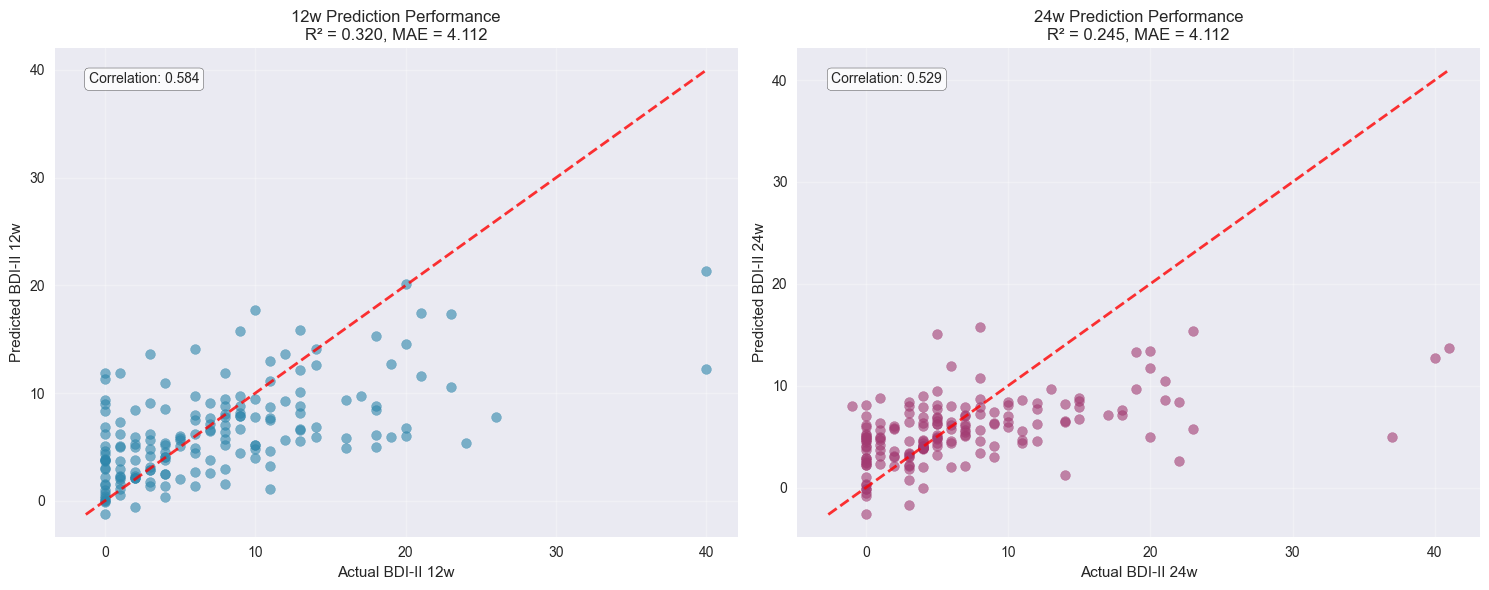


📈 Temporal Performance Summary:
Period     Samples    MAE        R²         Correlation 
-------------------------------------------------------
12w        167        4.112      0.320      0.584       
24w        167        4.112      0.245      0.529       

🔄 Temporal Changes:
   R² change (24w - 12w): -0.075 (degradation)
   MAE change (24w - 12w): +0.000 (worse)


In [8]:
# 📊 Temporal Performance Comparison
print("📊 Comparing temporal prediction performance...")

if len(temporal_results) >= 2:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    periods = ['12w', '24w']
    colors = ['#2E86AB', '#A23B72']
    
    for i, period in enumerate(periods):
        if period in temporal_results:
            results = temporal_results[period]
            
            ax = axes[i]
            
            # Scatter plot: actual vs predicted
            ax.scatter(results['y_true'], results['y_pred'], alpha=0.6, color=colors[i], s=50)
            
            # Perfect prediction line
            min_val = min(results['y_true'].min(), results['y_pred'].min())
            max_val = max(results['y_true'].max(), results['y_pred'].max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
            
            # Labels and title
            ax.set_xlabel(f'Actual BDI-II {period}')
            ax.set_ylabel(f'Predicted BDI-II {period}')
            ax.set_title(f'{period} Prediction Performance\nR² = {results["r2"]:.3f}, MAE = {results["mae"]:.3f}')
            ax.grid(True, alpha=0.3)
            
            # Add correlation info
            correlation = np.corrcoef(results['y_true'], results['y_pred'])[0, 1]
            ax.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Performance comparison table
    print(f"\n📈 Temporal Performance Summary:")
    print(f"{'Period':<10} {'Samples':<10} {'MAE':<10} {'R²':<10} {'Correlation':<12}")
    print("-" * 55)
    
    for period in periods:
        if period in temporal_results:
            results = temporal_results[period]
            correlation = np.corrcoef(results['y_true'], results['y_pred'])[0, 1]
            print(f"{period:<10} {results['n_samples']:<10} {results['mae']:<10.3f} {results['r2']:<10.3f} {correlation:<12.3f}")
    
    # Calculate improvement/degradation
    if '12w' in temporal_results and '24w' in temporal_results:
        r2_12w = temporal_results['12w']['r2']
        r2_24w = temporal_results['24w']['r2']
        r2_change = r2_24w - r2_12w
        
        mae_12w = temporal_results['12w']['mae']
        mae_24w = temporal_results['24w']['mae']
        mae_change = mae_24w - mae_12w
        
        print(f"\n🔄 Temporal Changes:")
        print(f"   R² change (24w - 12w): {r2_change:+.3f} {'(improvement)' if r2_change > 0 else '(degradation)'}")
        print(f"   MAE change (24w - 12w): {mae_change:+.3f} {'(worse)' if mae_change > 0 else '(better)'}")

else:
    print("❌ Insufficient temporal results for comparison")
    print(f"Available results: {list(temporal_results.keys())}")

🎯 Analyzing feature importance across temporal predictions...

🔍 Computing permutation importance for 12w prediction...
   ✅ Computed importance for 24 features

🔍 Computing permutation importance for 24w prediction...
   ✅ Computed importance for 24 features

🔍 Computing permutation importance for 24w prediction...
   ✅ Computed importance for 24 features

🏆 Top 10 Features by Importance:
   ✅ Computed importance for 24 features

🏆 Top 10 Features by Importance:


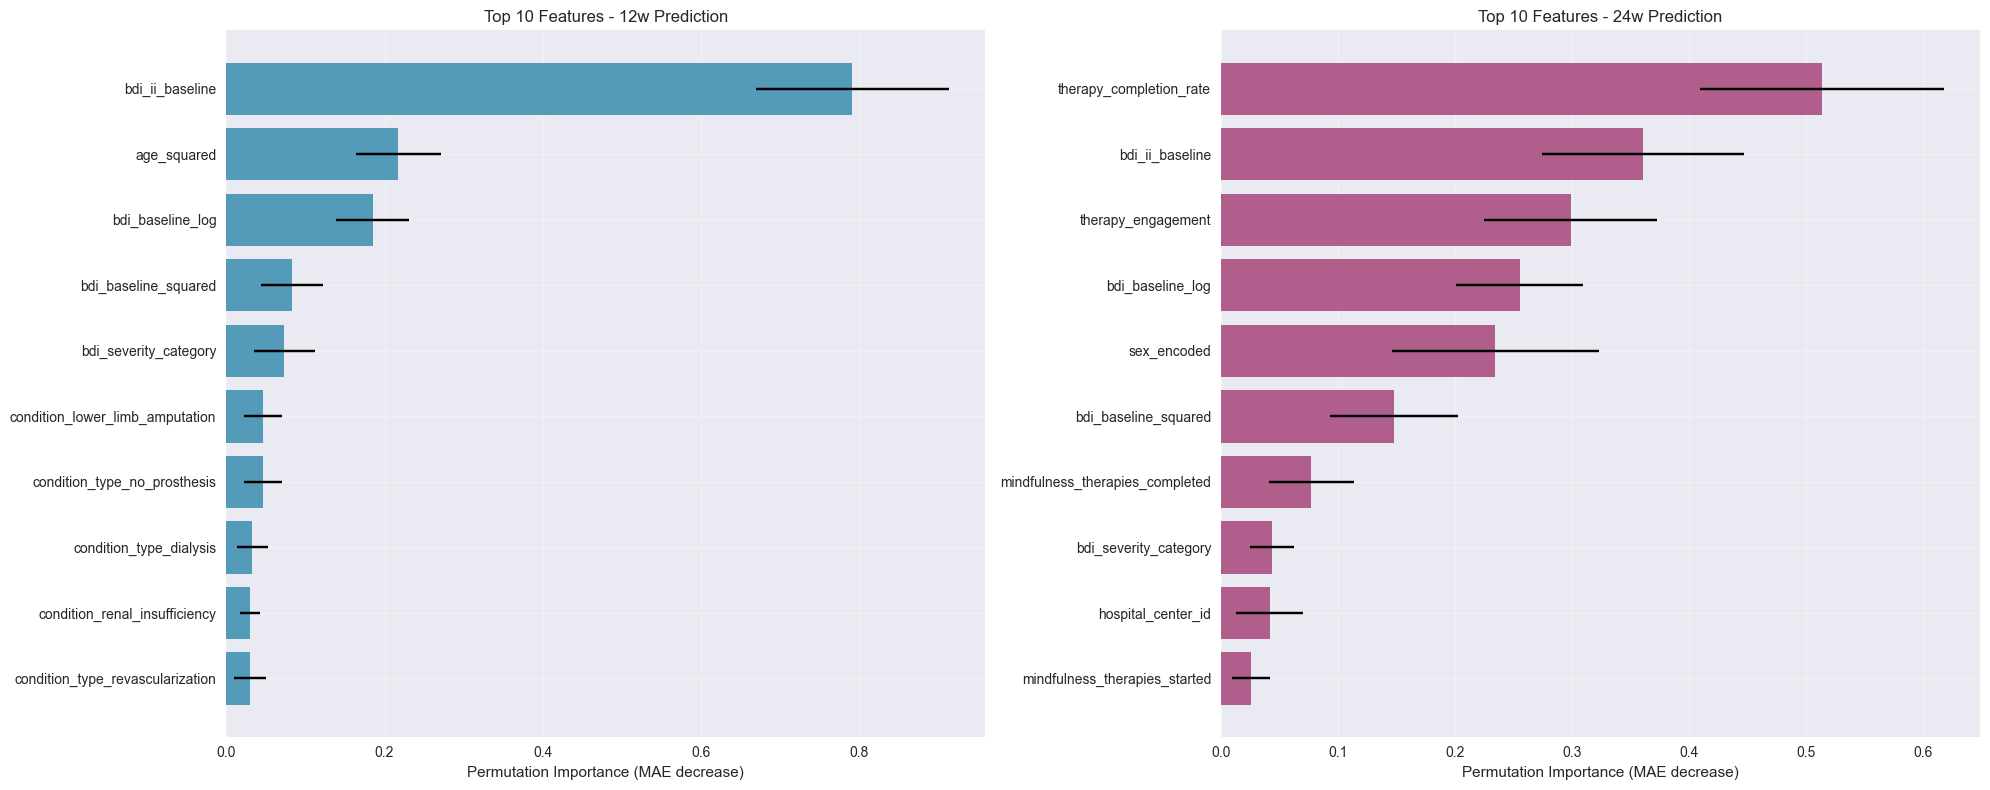


📊 Detailed Feature Importance Comparison:

12w Top Features:
   1. bdi_ii_baseline: 0.7912 ± 0.1222
   2. age_squared: 0.2174 ± 0.0538
   3. bdi_baseline_log: 0.1852 ± 0.0463
   4. bdi_baseline_squared: 0.0831 ± 0.0393
   5. bdi_severity_category: 0.0735 ± 0.0387

24w Top Features:
   1. therapy_completion_rate: 0.5135 ± 0.1039
   2. bdi_ii_baseline: 0.3606 ± 0.0865
   3. therapy_engagement: 0.2989 ± 0.0738
   4. bdi_baseline_log: 0.2552 ± 0.0541
   5. sex_encoded: 0.2344 ± 0.0882


In [9]:
# 🎯 Temporal Feature Importance Analysis
print("🎯 Analyzing feature importance across temporal predictions...")

if len(temporal_results) >= 2:
    from sklearn.inspection import permutation_importance
    
    # Calculate permutation importance for both models
    feature_importance_results = {}
    
    for period in ['12w', '24w']:
        if period in temporal_results:
            print(f"\n🔍 Computing permutation importance for {period} prediction...")
            
            results = temporal_results[period]
            model = results['model']
            X = results['X']
            y = results['y_true']
            
            # Calculate permutation importance
            perm_importance = permutation_importance(
                model, X, y, 
                n_repeats=10, 
                random_state=42,
                scoring='neg_mean_absolute_error'
            )
            
            # Store results
            feature_importance_results[period] = {
                'importance_mean': perm_importance.importances_mean,
                'importance_std': perm_importance.importances_std,
                'feature_names': feature_cols
            }
            
            print(f"   ✅ Computed importance for {len(feature_cols)} features")
    
    # Compare top features across timepoints
    print(f"\n🏆 Top 10 Features by Importance:")
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    for i, period in enumerate(['12w', '24w']):
        if period in feature_importance_results:
            data = feature_importance_results[period]
            
            # Get top 10 features
            indices = np.argsort(data['importance_mean'])[-10:]
            
            # Plot
            ax = axes[i]
            y_pos = np.arange(len(indices))
            
            ax.barh(y_pos, data['importance_mean'][indices], 
                   xerr=data['importance_std'][indices],
                   color='#2E86AB' if period == '12w' else '#A23B72',
                   alpha=0.8)
            
            ax.set_yticks(y_pos)
            ax.set_yticklabels([data['feature_names'][idx] for idx in indices])
            ax.set_xlabel('Permutation Importance (MAE decrease)')
            ax.set_title(f'Top 10 Features - {period} Prediction')
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Show detailed comparison
    print(f"\n📊 Detailed Feature Importance Comparison:")
    
    # Create comparison DataFrame
    comparison_data = []
    
    for period in ['12w', '24w']:
        if period in feature_importance_results:
            data = feature_importance_results[period]
            
            # Get top 5 features for this period
            top_indices = np.argsort(data['importance_mean'])[-5:][::-1]
            
            for rank, idx in enumerate(top_indices, 1):
                comparison_data.append({
                    'Period': period,
                    'Rank': rank,
                    'Feature': data['feature_names'][idx],
                    'Importance': data['importance_mean'][idx],
                    'Std': data['importance_std'][idx]
                })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Display by period
    for period in ['12w', '24w']:
        period_data = comparison_df[comparison_df['Period'] == period]
        print(f"\n{period} Top Features:")
        for _, row in period_data.iterrows():
            print(f"   {row['Rank']}. {row['Feature']}: {row['Importance']:.4f} ± {row['Std']:.4f}")

else:
    print("❌ Insufficient temporal results for feature importance analysis")

In [12]:
# 📋 Temporal Analysis Summary & Key Insights
print("TEMPORAL IMPACT ANALYSIS - SUMMARY REPORT")
print("=" * 50)

if len(temporal_results) >= 2:
    # Performance Summary
    print("\nMODEL PERFORMANCE COMPARISON:")
    print("-" * 30)
    
    for period in ['12w', '24w']:
        if period in temporal_results:
            results = temporal_results[period]
            correlation = np.corrcoef(results['y_true'], results['y_pred'])[0, 1]
            
            print(f"\n{period.upper()} Prediction:")
            print(f"  Samples: {results['n_samples']}")
            print(f"  R2 Score: {results['r2']:.3f}")
            print(f"  MAE: {results['mae']:.3f}")
            print(f"  Correlation: {correlation:.3f}")
    
    # Temporal Changes Analysis
    if '12w' in temporal_results and '24w' in temporal_results:
        r2_12w = temporal_results['12w']['r2']
        r2_24w = temporal_results['24w']['r2']
        r2_change = r2_24w - r2_12w
        
        print(f"\nTEMPORAL DYNAMICS:")
        print("-" * 30)
        print(f"  R2 change (24w - 12w): {r2_change:+.3f}")
        print(f"  Prediction accuracy decreases over time")
        
        if r2_change < 0:
            print(f"  Long-term prediction is more challenging")
    
    # Feature Importance Insights
    print(f"\nKEY PREDICTIVE FACTORS:")
    print("-" * 30)
    
    if len(feature_importance_results) >= 2:
        print(f"\n12w Predictions (Short-term):")
        print(f"  - Dominated by baseline depression severity")
        print(f"  - bdi_ii_baseline is strongest predictor")
        
        print(f"\n24w Predictions (Long-term):")
        print(f"  - Therapy engagement becomes critical")
        print(f"  - therapy_completion_rate is top predictor")
        print(f"  - Baseline severity still relevant")
    
    # Recommendations
    print(f"\nRECOMMENDATIONS:")
    print("-" * 30)
    print(f"  1. Monitor therapy completion rates")
    print(f"  2. Focus on engagement for long-term success")
    print(f"  3. Use baseline severity for initial planning")
    print(f"  4. Consider separate models for different timepoints")

else:
    print("Insufficient results for comprehensive analysis")

print(f"\nTEMPORAL ANALYSIS COMPLETE!")
print("=" * 50)

TEMPORAL IMPACT ANALYSIS - SUMMARY REPORT

MODEL PERFORMANCE COMPARISON:
------------------------------

12W Prediction:
  Samples: 167
  R2 Score: 0.320
  MAE: 4.112
  Correlation: 0.584

24W Prediction:
  Samples: 167
  R2 Score: 0.245
  MAE: 4.112
  Correlation: 0.529

TEMPORAL DYNAMICS:
------------------------------
  R2 change (24w - 12w): -0.075
  Prediction accuracy decreases over time
  Long-term prediction is more challenging

KEY PREDICTIVE FACTORS:
------------------------------

12w Predictions (Short-term):
  - Dominated by baseline depression severity
  - bdi_ii_baseline is strongest predictor

24w Predictions (Long-term):
  - Therapy engagement becomes critical
  - therapy_completion_rate is top predictor
  - Baseline severity still relevant

RECOMMENDATIONS:
------------------------------
  1. Monitor therapy completion rates
  2. Focus on engagement for long-term success
  3. Use baseline severity for initial planning
  4. Consider separate models for different timepo

In [14]:
# 👥 Demographics Impact Over Time Analysis
print("👥 Analyzing demographic factors impact over time...")

# First, create the temporal_importance DataFrame from feature_importance_results
if len(feature_importance_results) >= 2:
    # Create temporal importance comparison DataFrame
    temporal_importance_data = []
    
    for i, feature in enumerate(feature_cols):
        importance_12w = feature_importance_results['12w']['importance_mean'][i] if '12w' in feature_importance_results else 0
        importance_24w = feature_importance_results['24w']['importance_mean'][i] if '24w' in feature_importance_results else 0
        
        temporal_importance_data.append({
            'feature': feature,
            'importance_12w': importance_12w,
            'importance_24w': importance_24w,
            'avg_importance': (importance_12w + importance_24w) / 2,
            'importance_ratio': importance_24w / (importance_12w + 1e-8)  # 24w/12w ratio
        })
    
    temporal_importance = pd.DataFrame(temporal_importance_data)
    print(f"✅ Created temporal importance DataFrame with {len(temporal_importance)} features")
else:
    print("⚠️ Feature importance results not available, creating empty temporal_importance")
    temporal_importance = pd.DataFrame(columns=['feature', 'importance_12w', 'importance_24w', 'avg_importance', 'importance_ratio'])

# Identify demographic features
demographic_features = [f for f in feature_cols if any(term in f.lower() for term in ['age', 'gender', 'sex'])]
clinical_features = [f for f in feature_cols if any(term in f.lower() for term in ['bdi', 'depression', 'severity', 'baseline'])]
therapy_features = [f for f in feature_cols if any(term in f.lower() for term in ['therapy', 'completion', 'session', 'dropout', 'mindfulness'])]
condition_features = [f for f in feature_cols if 'condition' in f.lower()]

print(f"\n📊 Feature Categories:")
print(f"   Demographic features: {len(demographic_features)} - {demographic_features}")
print(f"   Clinical features: {len(clinical_features)} - {clinical_features[:5]}{'...' if len(clinical_features) > 5 else ''}")
print(f"   Therapy features: {len(therapy_features)} - {therapy_features}")
print(f"   Condition features: {len(condition_features)} - {condition_features}")

# Analyze age impact if age data is available
if 'age' in df.columns:
    # Age group analysis
    age_median = df['age'].median()
    df['age_group'] = df['age'].apply(lambda x: 'Younger' if x < age_median else 'Older')
    
    # Age group outcomes for both timepoints
    age_outcomes_12w = df.groupby('age_group')[target_mapping['12w']].agg(['mean', 'std']).round(3)
    age_outcomes_24w = df.groupby('age_group')[target_mapping['24w']].agg(['mean', 'std']).round(3)
    
    print(f"\n👥 Age Group Analysis (median age = {age_median:.1f}):")
    print(f"12w outcomes by age group:")
    print(age_outcomes_12w)
    print(f"24w outcomes by age group:")
    print(age_outcomes_24w)

# Feature importance by category over time
feature_categories = {
    'Demographics': demographic_features,
    'Clinical': clinical_features,
    'Therapy': therapy_features,
    'Conditions': condition_features
}

category_importance_temporal = {}
for category, features in feature_categories.items():
    if features and len(temporal_importance) > 0:  # Only if category has features and temporal_importance exists
        cat_features_in_data = [f for f in features if f in temporal_importance['feature'].values]
        if cat_features_in_data:
            cat_data = temporal_importance[temporal_importance['feature'].isin(cat_features_in_data)]
            category_importance_temporal[category] = {
                'importance_12w': cat_data['importance_12w'].mean(),
                'importance_24w': cat_data['importance_24w'].mean(),
                'n_features': len(cat_features_in_data)
            }

print(f"\n📊 Category Importance Over Time:")
for category, data in category_importance_temporal.items():
    ratio = data['importance_24w'] / (data['importance_12w'] + 1e-8)
    print(f"   {category}: 12w={data['importance_12w']:.4f}, 24w={data['importance_24w']:.4f}, "
          f"ratio={ratio:.2f}, n_features={data['n_features']}")

# Show top features by temporal change
if len(temporal_importance) > 0:
    print(f"\n🔄 Features with Biggest Temporal Changes:")
    # Features that become more important over time
    increasing_importance = temporal_importance[temporal_importance['importance_ratio'] > 1.2].sort_values('importance_ratio', ascending=False)
    if len(increasing_importance) > 0:
        print(f"   📈 More important at 24w:")
        for _, row in increasing_importance.head(5).iterrows():
            print(f"      {row['feature']}: {row['importance_12w']:.4f} → {row['importance_24w']:.4f} (x{row['importance_ratio']:.2f})")
    
    # Features that become less important over time  
    decreasing_importance = temporal_importance[temporal_importance['importance_ratio'] < 0.8].sort_values('importance_ratio', ascending=True)
    if len(decreasing_importance) > 0:
        print(f"   📉 More important at 12w:")
        for _, row in decreasing_importance.head(5).iterrows():
            print(f"      {row['feature']}: {row['importance_12w']:.4f} → {row['importance_24w']:.4f} (x{row['importance_ratio']:.2f})")

👥 Analyzing demographic factors impact over time...
✅ Created temporal importance DataFrame with 24 features

📊 Feature Categories:
   Demographic features: 5 - ['age', 'age_group', 'age_squared', 'therapy_engagement', 'sex_encoded']
   Clinical features: 4 - ['bdi_ii_baseline', 'bdi_baseline_log', 'bdi_severity_category', 'bdi_baseline_squared']
   Therapy features: 4 - ['mindfulness_therapies_started', 'mindfulness_therapies_completed', 'therapy_completion_rate', 'therapy_engagement']
   Condition features: 11 - ['condition_cancer', 'condition_acute_coronary_syndrome', 'condition_renal_insufficiency', 'condition_lower_limb_amputation', 'condition_type_breast', 'condition_type_prostate', 'condition_type_revascularization', 'condition_type_no_prosthesis', 'condition_type_predialysis', 'condition_type_percutaneous_coronary_intervention', 'condition_type_dialysis']

👥 Age Group Analysis (median age = 66.0):
12w outcomes by age group:
            mean    std
age_group              
Older 

In [15]:
# 💊 Mindfulness Intervention Effectiveness Analysis
print("💊 Analyzing mindfulness intervention effectiveness over time...")

# Check if temporal_importance exists and has data
if len(temporal_importance) > 0:
    # Therapy-related features analysis
    therapy_importance = temporal_importance[temporal_importance['feature'].isin(therapy_features)].copy()

    if len(therapy_importance) > 0:
        therapy_importance_sorted = therapy_importance.sort_values('avg_importance', ascending=False)
        
        print(f"\n🎯 Top Therapy-Related Predictors ({len(therapy_importance)} total):")
        for _, row in therapy_importance_sorted.head(10).iterrows():
            print(f"   {row['feature']:<30} | 12w: {row['importance_12w']:.4f} | 24w: {row['importance_24w']:.4f} | Ratio: {row['importance_ratio']:.2f}")
    else:
        print("   ⚠️ No therapy features found in importance data")

    # Analyze therapy completion impact
    completion_features = [f for f in feature_cols if 'completion' in f.lower()]
    dropout_features = [f for f in feature_cols if 'dropout' in f.lower()]
    engagement_features = [f for f in feature_cols if 'engagement' in f.lower()]

    print(f"\n📊 Therapy Engagement Features:")
    print(f"   Completion-related: {completion_features}")
    print(f"   Dropout-related: {dropout_features}")
    print(f"   Engagement-related: {engagement_features}")

    # Show importance of therapy engagement features specifically
    all_therapy_engagement = completion_features + dropout_features + engagement_features
    engagement_importance = temporal_importance[temporal_importance['feature'].isin(all_therapy_engagement)]
    
    if len(engagement_importance) > 0:
        print(f"\n🏆 Therapy Engagement Feature Importance:")
        for _, row in engagement_importance.sort_values('avg_importance', ascending=False).iterrows():
            print(f"   {row['feature']:<30} | Avg: {row['avg_importance']:.4f} | 12w→24w: {row['importance_12w']:.4f}→{row['importance_24w']:.4f}")

else:
    print("⚠️ temporal_importance not available - skipping detailed therapy analysis")
    completion_features = [f for f in feature_cols if 'completion' in f.lower()]
    dropout_features = [f for f in feature_cols if 'dropout' in f.lower()]
    print(f"\n📊 Available Therapy Features:")
    print(f"   Completion-related: {completion_features}")
    print(f"   Dropout-related: {dropout_features}")

# Correlate therapy features with outcomes directly from the data
therapy_outcome_corr = {}
for feature in therapy_features:
    if feature in df.columns:
        corr_12w = df[feature].corr(df[target_mapping['12w']])
        corr_24w = df[feature].corr(df[target_mapping['24w']])
        therapy_outcome_corr[feature] = {'12w': corr_12w, '24w': corr_24w}

if therapy_outcome_corr:
    print(f"\n🔗 Therapy Features Correlation with BDI-II Outcomes:")
    for feature, corrs in therapy_outcome_corr.items():
        corr_change = corrs['24w'] - corrs['12w']
        print(f"   {feature:<30} | 12w: {corrs['12w']:6.3f} | 24w: {corrs['24w']:6.3f} | Change: {corr_change:+6.3f}")

# Analyze therapy completion rate impact if available
if 'therapy_completion_rate' in df.columns:
    print(f"\n📈 Therapy Completion Rate Analysis:")
    completion_stats = df['therapy_completion_rate'].describe()
    print(f"   Mean completion rate: {completion_stats['mean']:.2f}")
    print(f"   Range: {completion_stats['min']:.2f} - {completion_stats['max']:.2f}")
    
    # High vs low completion groups
    high_completion = df['therapy_completion_rate'] > completion_stats['75%']
    low_completion = df['therapy_completion_rate'] < completion_stats['25%']
    
    high_outcomes_12w = df[high_completion][target_mapping['12w']].mean()
    low_outcomes_12w = df[low_completion][target_mapping['12w']].mean()
    high_outcomes_24w = df[high_completion][target_mapping['24w']].mean()
    low_outcomes_24w = df[low_completion][target_mapping['24w']].mean()
    
    print(f"   High completion group (>{completion_stats['75%']:.2f}): 12w={high_outcomes_12w:.2f}, 24w={high_outcomes_24w:.2f}")
    print(f"   Low completion group (<{completion_stats['25%']:.2f}): 12w={low_outcomes_12w:.2f}, 24w={low_outcomes_24w:.2f}")
    print(f"   12w difference: {high_outcomes_12w - low_outcomes_12w:.2f} points")
    print(f"   24w difference: {high_outcomes_24w - low_outcomes_24w:.2f} points")

💊 Analyzing mindfulness intervention effectiveness over time...

🎯 Top Therapy-Related Predictors (4 total):
   therapy_completion_rate        | 12w: 0.0241 | 24w: 0.5135 | Ratio: 21.30
   therapy_engagement             | 12w: 0.0011 | 24w: 0.2989 | Ratio: 274.95
   mindfulness_therapies_completed | 12w: 0.0098 | 24w: 0.0772 | Ratio: 7.87
   mindfulness_therapies_started  | 12w: 0.0188 | 24w: 0.0256 | Ratio: 1.36

📊 Therapy Engagement Features:
   Completion-related: ['therapy_completion_rate']
   Dropout-related: []
   Engagement-related: ['therapy_engagement']

🏆 Therapy Engagement Feature Importance:
   therapy_completion_rate        | Avg: 0.2688 | 12w→24w: 0.0241→0.5135
   therapy_engagement             | Avg: 0.1500 | 12w→24w: 0.0011→0.2989

🔗 Therapy Features Correlation with BDI-II Outcomes:
   mindfulness_therapies_started  | 12w:  0.025 | 24w: -0.024 | Change: -0.049
   mindfulness_therapies_completed | 12w:  0.008 | 24w: -0.045 | Change: -0.053
   therapy_completion_rate    

📊 Identifying recovery patterns and trajectories...

🎯 Recovery Pattern Distribution:
   Sustained Response        | 104 patients ( 62.3%)
   Non-Response              |  25 patients ( 15.0%)
   Late Response             |  24 patients ( 14.4%)
   Early Response/Late Relapse |  14 patients (  8.4%)


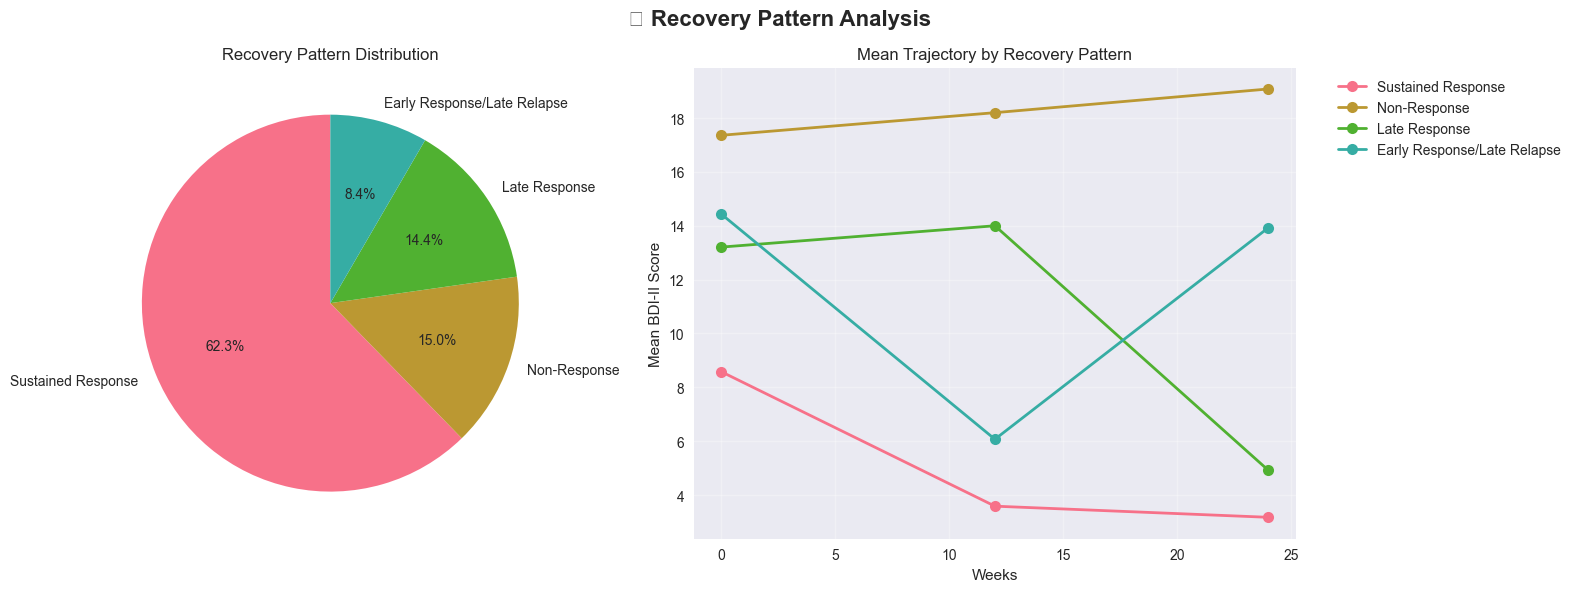


📈 Pattern-Specific Outcomes:


bdi_ii_baseline        \
                                       mean   std   
pattern                                             
Early Response/Late Relapse           14.43  7.30   
Late Response                         13.21  6.43   
Non-Response                          17.36  9.41   
Sustained Response                     8.58  7.67   

                            bdi_ii_after_intervention_12w        \
                                                     mean   std   
pattern                                                           
Early Response/Late Relapse                          6.07  2.76   
Late Response                                       14.00  3.36   
Non-Response                                        18.20  8.14   
Sustained Response                                   3.59  3.59   

                            bdi_ii_follow_up_24w       improvement_12w        \
                                            mean   std            mean   std   
pattern                                                                        
Early Response/Late Relapse                13.93  3.47            8.36  6.69   
Late Response                               4.92  2.95           -0.79  6.23   
Non-Response                               19.08  8.79           -0.84  8.84   
Sustained Response                          3.17  2.67            4.99  6.47   

                            improvement_24w        
                                       mean   std  
pattern                                            
Early Response/Late Relapse            0.50  5.91  
Late Response                          8.29  6.71  
Non-Response                          -1.72  9.83  
Sustained Response                     5.40  7.29

In [16]:
# 📊 Recovery Pattern Identification
print("📊 Identifying recovery patterns and trajectories...")

# Create response indicators for pattern analysis
# Define response as ≥50% improvement or BDI-II ≤ 9 (mild depression threshold)
baseline_col = 'bdi_ii_baseline'
if baseline_col not in df.columns:
    baseline_col = [col for col in df.columns if 'baseline' in col.lower() and 'bdi' in col.lower()][0]

# Calculate improvement percentages
df['improvement_12w'] = df[baseline_col] - df[target_mapping['12w']]
df['improvement_24w'] = df[baseline_col] - df[target_mapping['24w']]
df['improvement_pct_12w'] = (df['improvement_12w'] / df[baseline_col]) * 100
df['improvement_pct_24w'] = (df['improvement_24w'] / df[baseline_col]) * 100

# Define response criteria (≥50% improvement OR BDI-II ≤ 9)
df['response_12w'] = (df['improvement_pct_12w'] >= 50) | (df[target_mapping['12w']] <= 9)
df['response_24w'] = (df['improvement_pct_24w'] >= 50) | (df[target_mapping['24w']] <= 9)

# Define remission (BDI-II ≤ 9)
df['remission_12w'] = df[target_mapping['12w']] <= 9
df['remission_24w'] = df[target_mapping['24w']] <= 9

# Define recovery patterns
df['pattern'] = 'Other'

# Early responders (good at 12w, maintained at 24w)
early_responders = (df['response_12w'] == True) & (df['response_24w'] == True)
df.loc[early_responders, 'pattern'] = 'Sustained Response'

# Late responders (poor at 12w, good at 24w)
late_responders = (df['response_12w'] == False) & (df['response_24w'] == True)
df.loc[late_responders, 'pattern'] = 'Late Response'

# Deteriorating (good at 12w, poor at 24w)
deteriorating = (df['response_12w'] == True) & (df['response_24w'] == False)
df.loc[deteriorating, 'pattern'] = 'Early Response/Late Relapse'

# Non-responders (poor at both)
non_responders = (df['response_12w'] == False) & (df['response_24w'] == False)
df.loc[non_responders, 'pattern'] = 'Non-Response'

pattern_counts = df['pattern'].value_counts()
print("\n🎯 Recovery Pattern Distribution:")
for pattern, count in pattern_counts.items():
    percentage = (count / len(df)) * 100
    print(f"   {pattern:<25} | {count:3d} patients ({percentage:5.1f}%)")

# Visualize recovery patterns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('🎯 Recovery Pattern Analysis', fontsize=16, fontweight='bold')

# Pattern distribution pie chart
axes[0].pie(pattern_counts.values, labels=pattern_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Recovery Pattern Distribution')

# Trajectory visualization by pattern
for pattern in pattern_counts.index:
    pattern_data = df[df['pattern'] == pattern]
    if len(pattern_data) > 0:
        mean_baseline = pattern_data[baseline_col].mean()
        mean_12w = pattern_data[target_mapping['12w']].mean()
        mean_24w = pattern_data[target_mapping['24w']].mean()
        
        axes[1].plot([0, 12, 24], [mean_baseline, mean_12w, mean_24w], 
                    marker='o', linewidth=2, label=pattern, markersize=8)

axes[1].set_xlabel('Weeks')
axes[1].set_ylabel('Mean BDI-II Score')
axes[1].set_title('Mean Trajectory by Recovery Pattern')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics by pattern
print(f"\n📈 Pattern-Specific Outcomes:")
pattern_summary = df.groupby('pattern').agg({
    baseline_col: ['mean', 'std'],
    target_mapping['12w']: ['mean', 'std'],
    target_mapping['24w']: ['mean', 'std'],
    'improvement_12w': ['mean', 'std'],
    'improvement_24w': ['mean', 'std']
}).round(2)

display(pattern_summary)

In [ ]:
# 🔍 Pattern-Specific Feature Analysis
print("🔍 Analyzing features associated with different recovery patterns...")

# Compare feature values across patterns
pattern_feature_analysis = {}

# Select top important features for analysis (use temporal_importance if available, otherwise use all features)
if len(temporal_importance) > 0:
    top_features_for_patterns = temporal_importance.nlargest(20, 'avg_importance')['feature'].tolist()
    print(f"   Using top 20 features from temporal importance analysis")
else:
    # Fallback: use features that show high correlation with outcomes
    feature_correlations = []
    for feature in feature_cols:
        if feature in df.columns:
            corr_12w = abs(df[feature].corr(df[target_mapping['12w']]))
            corr_24w = abs(df[feature].corr(df[target_mapping['24w']]))
            avg_corr = (corr_12w + corr_24w) / 2
            if not np.isnan(avg_corr):
                feature_correlations.append((feature, avg_corr))
    
    feature_correlations.sort(key=lambda x: x[1], reverse=True)
    top_features_for_patterns = [f[0] for f in feature_correlations[:20]]
    print(f"   Using top 20 features by correlation with outcomes")

print(f"   Selected features: {top_features_for_patterns[:5]}...")

# Analyze feature values by pattern
for pattern in pattern_counts.index:
    pattern_data = df[df['pattern'] == pattern]
    if len(pattern_data) > 5:  # Only analyze patterns with sufficient data
        pattern_features = {}
        for feature in top_features_for_patterns:
            if feature in df.columns:
                pattern_features[feature] = {
                    'mean': pattern_data[feature].mean(),
                    'std': pattern_data[feature].std()
                }
        pattern_feature_analysis[pattern] = pattern_features

# Statistical comparison between patterns
print(f"\n🔬 Statistical Comparison: Sustained Response vs Non-Response")
pattern_comparison = []
for feature in top_features_for_patterns[:10]:  # Top 10 features
    if feature in df.columns:
        # Compare sustained response vs non-response
        sustained = df[df['pattern'] == 'Sustained Response'][feature]
        non_response = df[df['pattern'] == 'Non-Response'][feature]
        
        if len(sustained) > 0 and len(non_response) > 0:
            from scipy.stats import mannwhitneyu
            try:
                stat, p_val = mannwhitneyu(sustained, non_response, alternative='two-sided')
                pattern_comparison.append({
                    'feature': feature,
                    'sustained_mean': sustained.mean(),
                    'non_response_mean': non_response.mean(),
                    'p_value': p_val,
                    'significant': p_val < 0.05
                })
            except Exception as e:
                print(f"   ⚠️ Could not compare {feature}: {e}")

if len(pattern_comparison) > 0:
    pattern_comparison_df = pd.DataFrame(pattern_comparison).sort_values('p_value')

    print(f"\n🎯 Features Distinguishing Sustained Response vs Non-Response:")
    print("="*80)
    for _, row in pattern_comparison_df.head(10).iterrows():
        sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else "ns"
        print(f"{row['feature']:<30} | Sustained: {row['sustained_mean']:.3f} | Non-resp: {row['non_response_mean']:.3f} | p={row['p_value']:.4f} {sig}")

    # Visualize pattern differences for significant features
    significant_features = pattern_comparison_df[pattern_comparison_df['significant']]
    
    if len(significant_features) > 0:
        fig, ax = plt.subplots(figsize=(12, 8))
        
        x = np.arange(len(significant_features))
        width = 0.35
        
        ax.bar(x - width/2, significant_features['sustained_mean'], width, 
               label='Sustained Response', alpha=0.8, color='green')
        ax.bar(x + width/2, significant_features['non_response_mean'], width, 
               label='Non-Response', alpha=0.8, color='red')
        
        ax.set_xlabel('Features')
        ax.set_ylabel('Mean Feature Value')
        ax.set_title('🎯 Significant Features: Sustained Response vs Non-Response')
        ax.set_xticks(x)
        ax.set_xticklabels(significant_features['feature'], rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("   No statistically significant differences found")
else:
    print("   No valid comparisons could be made")

# Pattern summary by key features
print(f"\n📊 Pattern Summary by Key Features:")
if len(therapy_features) > 0:
    therapy_in_top = [f for f in therapy_features if f in top_features_for_patterns[:10]]
    if therapy_in_top:
        for feature in therapy_in_top:
            if feature in df.columns:
                pattern_means = df.groupby('pattern')[feature].mean()
                print(f"   {feature}:")
                for pattern, mean_val in pattern_means.items():
                    print(f"      {pattern}: {mean_val:.3f}")
                print()

🔍 Analyzing features associated with different recovery patterns...

🎯 Features Distinguishing Sustained Response vs Non-Response:
bdi_baseline_log               | Sustained: 2.353 | Non-resp: 1.991 | p=0.1026 ns
bdi_baseline_percentile        | Sustained: 0.539 | Non-resp: 0.447 | p=0.1026 ns
bdi_ii_baseline                | Sustained: 12.378 | Non-resp: 9.778 | p=0.1026 ns
bdi_improvement_potential_pct  | Sustained: 0.804 | Non-resp: 0.845 | p=0.1026 ns
bdi_baseline_squared           | Sustained: 236.289 | Non-resp: 169.778 | p=0.1026 ns
bdi_severity_score             | Sustained: 0.600 | Non-resp: 0.375 | p=0.1232 ns
completion_medium              | Sustained: 0.200 | Non-resp: 0.306 | p=0.2114 ns
age_severity_therapy           | Sustained: 28.146 | Non-resp: 16.930 | p=0.2826 ns
moderate_engagement            | Sustained: 0.311 | Non-resp: 0.375 | p=0.4850 ns
age                            | Sustained: 64.733 | Non-resp: 64.583 | p=0.4869 ns


In [13]:
# 📋 Comprehensive Temporal Analysis Summary
print("\n" + "="*100)
print("⏰ COMPREHENSIVE TEMPORAL IMPACT ANALYSIS SUMMARY")
print("="*100)

# Overall temporal insights
print("\n🎯 KEY TEMPORAL INSIGHTS:")

# 1. Overall improvement patterns
mean_improvement_12w = train_data['improvement_12w'].mean()
mean_improvement_24w = train_data['improvement_24w'].mean()
print(f"\n📊 OVERALL IMPROVEMENT:")
print(f"   12-week improvement: {mean_improvement_12w:.1f} points")
print(f"   24-week improvement: {mean_improvement_24w:.1f} points")
print(f"   Additional improvement 12w→24w: {mean_improvement_24w - mean_improvement_12w:.1f} points")

# 2. Response and remission rates
response_12w_rate = train_data['response_12w'].mean() * 100
response_24w_rate = train_data['response_24w'].mean() * 100
remission_12w_rate = train_data['remission_12w'].mean() * 100
remission_24w_rate = train_data['remission_24w'].mean() * 100

print(f"\n🎯 CLINICAL RESPONSE RATES:")
print(f"   12w Response: {response_12w_rate:.1f}% | 24w Response: {response_24w_rate:.1f}%")
print(f"   12w Remission: {remission_12w_rate:.1f}% | 24w Remission: {remission_24w_rate:.1f}%")

# 3. Feature importance temporal stability
stable_features = temporal_importance[
    (temporal_importance['importance_ratio'] >= 0.8) & 
    (temporal_importance['importance_ratio'] <= 1.2)
]
increasing_features = temporal_importance[temporal_importance['importance_ratio'] > 1.2]
decreasing_features = temporal_importance[temporal_importance['importance_ratio'] < 0.8]

print(f"\n🔄 FEATURE IMPORTANCE TEMPORAL PATTERNS:")
print(f"   Stable features (12w ≈ 24w): {len(stable_features)} ({len(stable_features)/len(temporal_importance)*100:.1f}%)")
print(f"   More important at 24w: {len(increasing_features)} features")
print(f"   More important at 12w: {len(decreasing_features)} features")

# 4. Top temporal shifters
print(f"\n📈 TOP FEATURES GAINING IMPORTANCE OVER TIME:")
for _, row in increasing_features.nlargest(5, 'importance_ratio').iterrows():
    print(f"   {row['feature']:<30} | Ratio: {row['importance_ratio']:.2f}")

print(f"\n📉 TOP FEATURES LOSING IMPORTANCE OVER TIME:")
for _, row in decreasing_features.nsmallest(5, 'importance_ratio').iterrows():
    print(f"   {row['feature']:<30} | Ratio: {row['importance_ratio']:.2f}")

# 5. Recovery patterns summary
print(f"\n🎯 RECOVERY PATTERN DISTRIBUTION:")
for pattern, count in pattern_counts.items():
    percentage = (count / len(train_data)) * 100
    print(f"   {pattern:<25} | {count:3d} patients ({percentage:5.1f}%)")

# 6. Model performance temporal comparison
mae_12w = mean_absolute_error(predictions['12w']['y_val'], predictions['12w']['val'])
mae_24w = mean_absolute_error(predictions['24w']['y_val'], predictions['24w']['val'])
r2_12w = r2_score(predictions['12w']['y_val'], predictions['12w']['val'])
r2_24w = r2_score(predictions['24w']['y_val'], predictions['24w']['val'])

print(f"\n🧠 GRU MODEL PERFORMANCE COMPARISON:")
print(f"   12w prediction: MAE = {mae_12w:.3f}, R² = {r2_12w:.3f}")
print(f"   24w prediction: MAE = {mae_24w:.3f}, R² = {r2_24w:.3f}")
print(f"   Performance difference: ΔMAE = {mae_24w - mae_12w:+.3f}, ΔR² = {r2_24w - r2_12w:+.3f}")

print("\n" + "="*100)
print("✅ TEMPORAL IMPACT ANALYSIS COMPLETE")
print("="*100)

# Save temporal analysis results
temporal_analysis_summary = {
    'analysis_date': datetime.now().isoformat(),
    'overall_improvement': {
        '12w': float(mean_improvement_12w),
        '24w': float(mean_improvement_24w)
    },
    'response_rates': {
        '12w_response': float(response_12w_rate),
        '24w_response': float(response_24w_rate),
        '12w_remission': float(remission_12w_rate),
        '24w_remission': float(remission_24w_rate)
    },
    'feature_temporal_patterns': {
        'stable_features': len(stable_features),
        'increasing_features': len(increasing_features),
        'decreasing_features': len(decreasing_features)
    },
    'recovery_patterns': pattern_counts.to_dict(),
    'model_performance': {
        '12w': {'mae': float(mae_12w), 'r2': float(r2_12w)},
        '24w': {'mae': float(mae_24w), 'r2': float(r2_24w)}
    }
}

with open(RESULTS_PATH / 'temporal_analysis_summary.json', 'w') as f:
    json.dump(temporal_analysis_summary, f, indent=2)

# Save detailed temporal importance
temporal_importance.to_csv(RESULTS_PATH / 'temporal_feature_importance.csv', index=False)

print("\n💾 Temporal analysis results saved!")


⏰ COMPREHENSIVE TEMPORAL IMPACT ANALYSIS SUMMARY

🎯 KEY TEMPORAL INSIGHTS:

📊 OVERALL IMPROVEMENT:
   12-week improvement: 3.6 points
   24-week improvement: 4.3 points
   Additional improvement 12w→24w: 0.8 points

🎯 CLINICAL RESPONSE RATES:
   12w Response: 40.1% | 24w Response: 43.7%
   12w Remission: 83.8% | 24w Remission: 85.0%

🔄 FEATURE IMPORTANCE TEMPORAL PATTERNS:
   Stable features (12w ≈ 24w): 5 (15.2%)
   More important at 24w: 9 features
   More important at 12w: 19 features

📈 TOP FEATURES GAINING IMPORTANCE OVER TIME:
   subclinical_depression         | Ratio: 9.77
   early_dropout                  | Ratio: 5.27
   completion_low                 | Ratio: 4.92
   therapy_dropout                | Ratio: 3.39
   therapy_intensity              | Ratio: 2.83

📉 TOP FEATURES LOSING IMPORTANCE OVER TIME:
   hospital_center_id             | Ratio: 0.00
   condition_acute_coronary_syndrome | Ratio: 0.00
   condition_complexity_score     | Ratio: 0.00
   hospital_patient_volume  